In [1]:
!pip install opencv-contrib-python

  Using cached opencv_contrib_python-4.6.0.66-cp36-abi3-win_amd64.whl (42.5 MB)


In [1]:
import numpy as np
import cv2, PIL
from cv2 import aruco
import glob
import depthai  # depthai - access the camera and its data packets
import matplotlib.pyplot as plt


In [2]:
def getMonoCamera(pipeline, isLeft):
    #configure mono camera
    mono = pipeline.createMonoCamera()

    #set the Camera Resolution
    mono.setResolution(depthai.MonoCameraProperties.SensorResolution.THE_720_P)
    if isLeft:
        mono.setBoardSocket(depthai.CameraBoardSocket.LEFT)
    else:
        mono.setBoardSocket(depthai.CameraBoardSocket.RIGHT)
    return mono

In [3]:
pipeline = depthai.Pipeline()
#set up left and right cameras
monoLeft = getMonoCamera(pipeline, isLeft = True)
monoRight = getMonoCamera(pipeline, isLeft = False)

#set output Xlink for left camera
xoutLeft = pipeline.createXLinkOut()
xoutLeft.setStreamName("left")

#set output Xlink for right camera
xoutRight = pipeline.createXLinkOut()
xoutRight.setStreamName("right")

#Attach cameras to output XLink 
monoLeft.out.link(xoutLeft.input)
monoRight.out.link(xoutRight.input)



In [4]:
with depthai.Device(pipeline) as device:
    q_left = device.getOutputQueue("left", 1, False)
    q_right = device.getOutputQueue("right", 1, False)
    count = 0
    while True:
        frame_left = q_left.get().getCvFrame()
        frame_right = q_right.get().getCvFrame()
        cv2.imshow("left", frame_left)
        cv2.imshow("right", frame_right)
        if cv2.waitKey(1) == ord('w'):
            cv2.imwrite('image_set/image_left.jpg', frame_left)
            cv2.imwrite('image_set/image_right.jpg', frame_right)

        if cv2.waitKey(1) == ord('q'):
            break
cv2.destroyAllWindows()


In [5]:
def get_aruco_data(img, aruco_dict, parameters):
    corners, ids, rejectedImgPoints = aruco.detectMarkers(img, aruco_dict, parameters=parameters)
    frame_markers = aruco.drawDetectedMarkers(img, corners, ids)
    return frame_markers, corners, ids

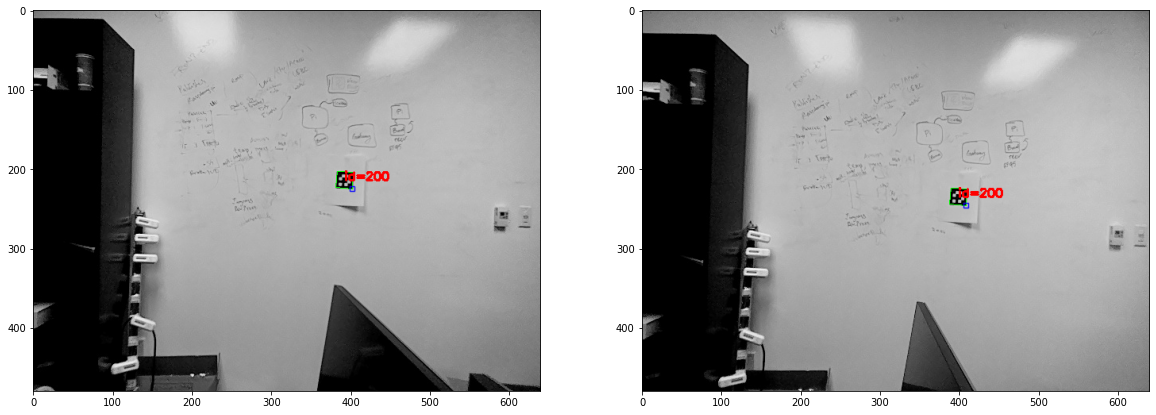

In [6]:
img_left = cv2.imread('image_set/image_left.jpg')
img_right = cv2.imread('image_set/image_right.jpg')

# get aruco markers
aruco_dict = cv2.aruco.Dictionary_get(aruco.DICT_4X4_250)
aruco_params = cv2.aruco.DetectorParameters_create()

markers_left, corners_left, ids_left = get_aruco_data(img_left, aruco_dict, aruco_params)
markers_right, corners_right, ids_right = get_aruco_data(img_right, aruco_dict, aruco_params)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(markers_left)
plt.subplot(1,2,2)
plt.imshow(markers_right)


In [7]:
center_left = np.sum(corners_left[0][0], axis=0)/4
center_right = np.sum(corners_right[0][0], axis=0)/4
disparity = center_right - center_left
print(disparity)
print(center_left)
print(center_right)

[ 6. 21.]
[392.25 213.75]
[398.25 234.75]


In [9]:

baseline = 7.5
focal_length = 358.78439933

d = baseline * focal_length / np.linalg.norm(disparity)
print(d/100, 'm')

1.2320706599714728 m
